# Importante Note :
Codes are borrowed from [Asura;Full Preprocessing Tutorial](https://www.kaggle.com/asura93/full-preprocessing-tutorial)

## Introduction

Working with these files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by your CNN.



**This tutorial aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method.**

What we will cover:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.


---

Before we start, let's import some packages and determine the available patients.

In [3]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../input/sample_images/'
patients = ["2002.dcm","I43031.dcm","I42662.dcm"]
patients.sort()

# Loading the files
Dicom is the de-facto file standard in medical imaging. This is my first time working with it, but it seems to be fairly straight-forward.  These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). 

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.

Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset is one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata.

In [4]:
# Load the scans in given folder path
def load_scan(paths):
    slices = [pydicom.read_file(s) for s in paths]
        
    return slices

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [5]:
def get_pixels_hu(path):
    slices=pydicom.read_file(path)
    image =slices.pixel_array 
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)     
    intercept = float(slices.RescaleIntercept)
    slope = int(slices.RescaleSlope)
    if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's take a look at one of the patients.

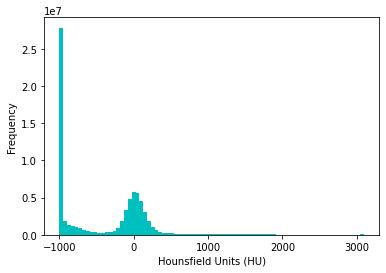

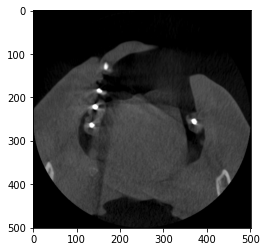

In [6]:
idx=2
patient=pydicom.read_file(patients[idx])
patient_pixels = get_pixels_hu(patients[idx])

np.save(patients[idx].split(".")[0]+".npy", patient_pixels)

plt.hist(patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(patient_pixels[80], cmap=plt.cm.gray)
plt.show()

Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue.

##Critiquing the Histogram

The histogram suggests the following:

    There is lots of air
    There is some lung
    There's an abundance of soft tissue, mostly muscle, liver, etc, but there's also some fat.
    There is only a small bit of bone (seen as a tiny sliver of height between 700-3000)

This observation means that we will need to do significant preprocessing if we want to process lesions in the lung tissue because only a tiny bit of the voxels represent lung.


#Displaying an Image Stack

We don't have a lot of screen real estate, so we'll be skipping every 3 slices to get a representative look at the study.



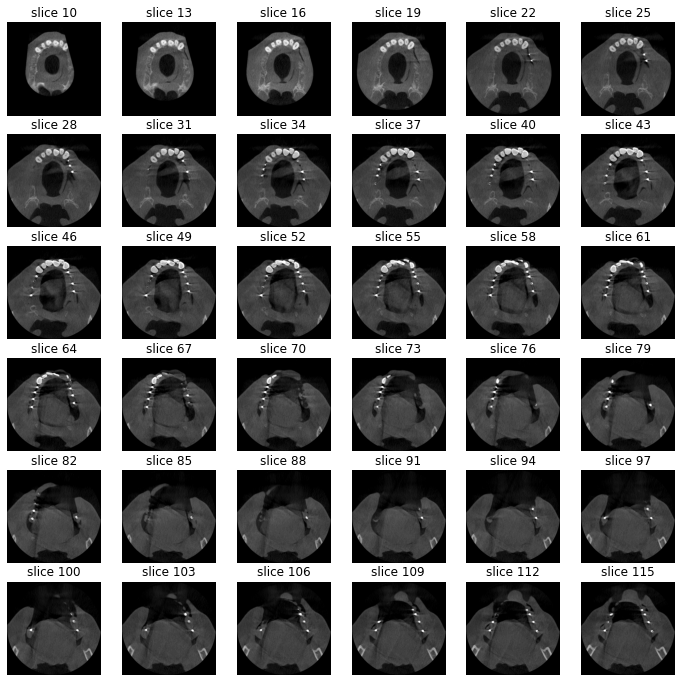

In [7]:
id = 0
imgs_to_process = np.load(patients[idx].split(".")[0]+".npy")

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

So as it turns out, what we were seeing as HU=-1000 are the voxels outside of the bore of the CT. "Air," in comparison, appears gray because it has a much higher value. As a result, the lungs and soft tissue have somewhat reduced contrast resolution as well.


# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [8]:
metadata=patient.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0]

print("Slice Thickness: %f" % metadata.SliceThickness) 
print("Pixel Spacing (row, col): (%f, %f) " % (metadata.PixelSpacing[0], metadata.PixelSpacing[1]))


Slice Thickness: 0.200000
Pixel Spacing (row, col): (0.200000, 0.200000) 


In [9]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    metadata=scan.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0]
    spacing = np.array([float(metadata.SliceThickness)] +[float(u) for u in metadata.PixelSpacing], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [10]:
pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
print("Shape before resampling\t", patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (301, 501, 501)
Shape after resampling	 (60, 100, 100)


# 3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

In [11]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface") 
    p = image.transpose(2,1,0)
    
    print("Calculating surface") 
    #verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing") 
    
    # Make the colormap single color since the axes are positional not intensity. 
    # colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing") 
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()


Our plot function takes a threshold argument which we can use to plot certain structures, such as all tissue or only the bones. 400 is a good threshold for showing the bones only (see Hounsfield unit table above). Let's do this!

In [12]:
#%matplotlib inline
#v, f = make_mesh(pix_resampled, 350)
#plt_3d(v, f)